# Stimulation

In [ ]:
import numpy as np
import time
from neuroplatform import StimShape, StimParam, IntanSoftware, Trigger, Experiment, StimPolarity
from fbm import FBM

def generate_oscillatory_sequence(length, frequency, amplitude=1):
    t = np.linspace(0, 1, length)
    oscillatory_sequence = amplitude * np.sin(2 * np.pi * frequency * t)
    return oscillatory_sequence

token = "XSALK6J9C4"
exp = Experiment(token)
print(f'Electrodes: {exp.electrodes}')

def generate_fbmn_sequence(length, min_val, max_val, hurst):
    f = FBM(n=length-1, hurst=hurst, length=1, method='daviesharte')
    fbmn = f.fbm()
    fbmn_normalized = min_val + (max_val - min_val) * (fbmn - np.min(fbmn)) / (np.max(fbmn) - np.min(fbmn))
    return fbmn_normalized

stim_params = []
for i in range(8):
    fractal_amplitude = generate_fbmn_sequence(40, 1, 8, 0.7)
    fractal_duration = generate_fbmn_sequence(40, 100, 200, 0.7)
    oscillatory_amplitude = generate_oscillatory_sequence(40, frequency=0.1, amplitude=1)  # Adding oscillations

    stim_param = StimParam()
    stim_param.index = exp.electrodes[0]
    stim_param.trigger_key = i
    stim_param.trigger_delay = 0
    stim_param.nb_pulse = 40
    stim_param.pulse_train_period = 5000000
    stim_param.post_stim_ref_period = 4999600.0
    stim_param.stim_shape = StimShape.Biphasic
    stim_param.polarity = StimPolarity.PositiveFirst
    stim_param.phase_duration1 = fractal_duration[i]
    stim_param.phase_duration2 = fractal_duration[i]
    stim_param.phase_amplitude1 = fractal_amplitude[i] + oscillatory_amplitude[i]
    stim_param.phase_amplitude2 = fractal_amplitude[i] + oscillatory_amplitude[i]
    stim_param.enable_amp_settle = True
    stim_param.pre_stim_amp_settle = 0.0
    stim_param.post_stim_amp_settle = 1000.0
    stim_param.enable_charge_recovery = True
    stim_param.post_charge_recovery_on = 0.0
    stim_param.post_charge_recovery_off = 100.0
    stim_param.interphase_delay = 0.0
    stim_params.append(stim_param)

intan = IntanSoftware()
trigger_gen = Trigger()

try:
    if exp.start():
        intan.impedance()
        intan.var_threshold(False)
        intan.send_stimparam(stim_params)
        trigger0 = np.zeros(16, dtype=np.uint8)
        for i in range(8):
            trigger0[i] = 1
            time.sleep(300)
            trigger_gen.send(trigger0)
            time.sleep(300)
            trigger0[i] = 0
        for stim in stim_params:
            stim.enable = False
        intan.send_stimparam(stim_params)
finally:
    trigger_gen.close()
    intan.var_threshold(True)
    intan.close()
    exp.stop()

# Visualisation

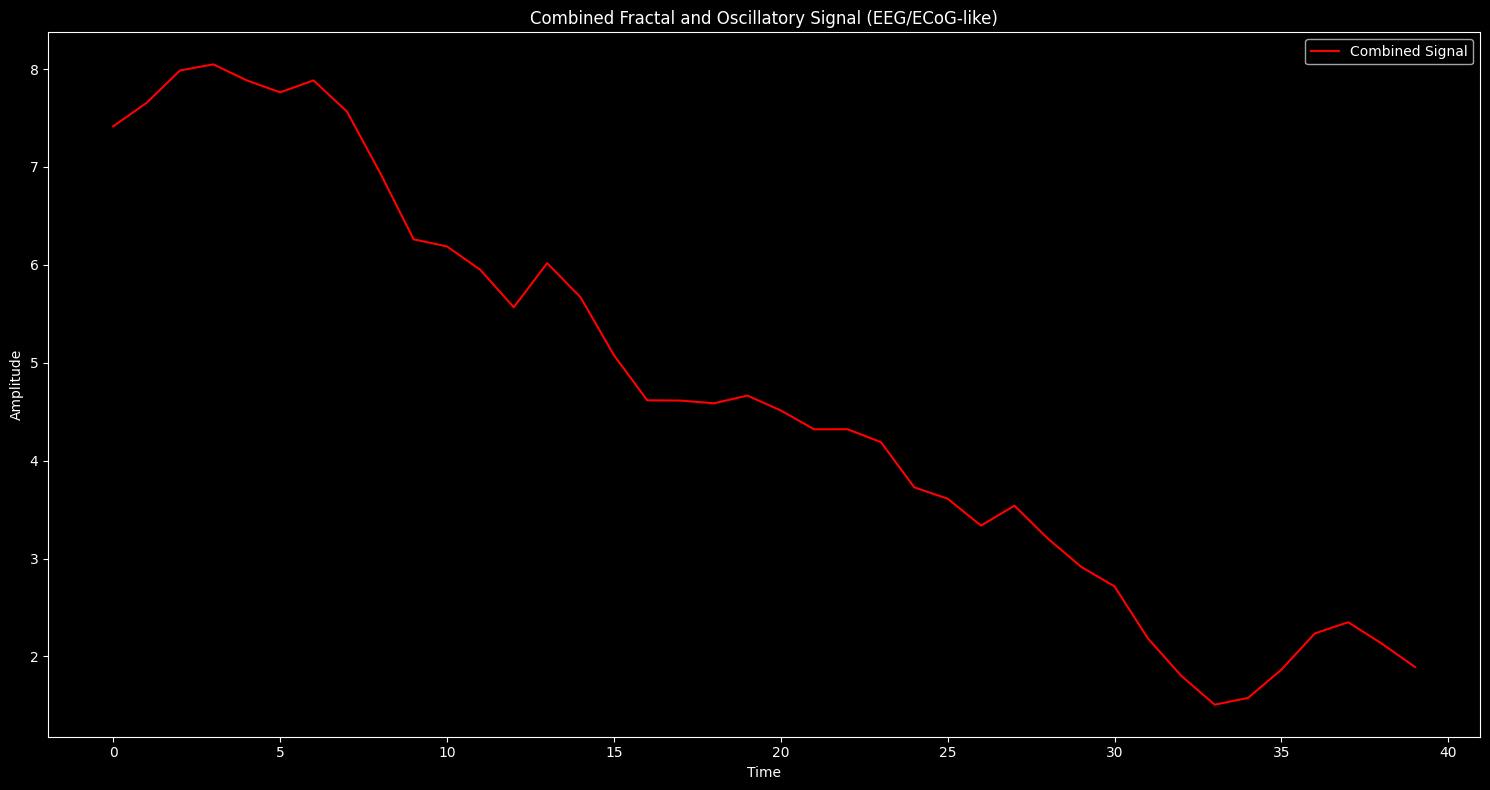

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from fbm import FBM

def generate_oscillatory_sequence(length, frequency, amplitude=1):
    t = np.linspace(0, 1, length)
    oscillatory_sequence = amplitude * np.sin(2 * np.pi * frequency * t)
    return oscillatory_sequence

def generate_fbmn_sequence(length, min_val, max_val, hurst):
    f = FBM(n=length-1, hurst=hurst, length=1, method='daviesharte')
    fbmn = f.fbm()
    fbmn_normalized = min_val + (max_val - min_val) * (fbmn - np.min(fbmn)) / (np.max(fbmn) - np.min(fbmn))
    return fbmn_normalized

# Parameters
length = 40
hurst = 0.7

# Generate sequences
fractal_amplitude = generate_fbmn_sequence(length, 1, 8, hurst)
oscillatory_amplitude = generate_oscillatory_sequence(length, frequency=0.1, amplitude=1)

# Combine sequences for visualization
combined_signal = fractal_amplitude + oscillatory_amplitude

# Plotting
plt.style.use('dark_background')

plt.figure(figsize=(15, 8))

plt.subplot(1, 1, 1)
plt.plot(combined_signal, color='red', label='Combined Signal')
plt.title('Combined Fractal and Oscillatory Signal (EEG/ECoG-like)', color='white')
plt.xlabel('Time', color='white')
plt.ylabel('Amplitude', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.legend()

plt.tight_layout()
plt.show()
